
# BPM Analysis Simulations

In [1]:

import json
import xtrack as xt
import xpart as xp
import xobjects as xo
import PyNAFF
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

context = xo.ContextCpu()

collider = xt.Multiline.from_json('../data/collider_thin.json')

line = collider['lhcb1']
for ii in line.elements:
   # if ii is a type 'multipole' 
    if type(ii) == xt.beam_elements.elements.Multipole:
        if len(ii.knl)>2:
            #print(ii)
            ii.knl[2] = 0

line.vars['i_oct_b1'] = 0
#line.vars['i_sext_b1'] = 0

line_edited = line.copy()
plt.close('all')

Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           
Done loading line from dict.           


In [2]:
np.where(np.array(line_edited.element_names)=='ip3')[0]
line_edited.element_names[42]

'mqwa.c4r3.b1..3'

## One particle initialization and inserstion of the BPM monitors


In [3]:
#Only one particle
my_particle = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)
line.particle_ref = my_particle
num_turns = 2000
sampling_frequency = 11245.5

num_particles = 3
monitor_ip3 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,
                                    num_particles=num_particles)
monitor_ip5 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,
                                    num_particles=num_particles)
monitor_ip8 = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns,
                                    num_particles=num_particles)
line.insert_element(index='ip3', element=monitor_ip3, name='mymon3')
line.insert_element(index='ip5', element=monitor_ip5, name='mymon5')
line.insert_element(index='ip8', element=monitor_ip8, name='mymon8')




line.build_tracker()


monitor = xt.ParticlesMonitor(_context=context,
                              start_at_turn=0, stop_at_turn=num_turns,
                              num_particles=num_particles)
line.track(my_particle, num_turns=num_turns, freeze_longitudinal=True)

aux = line.twiss()

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_longitudinal`.


In [4]:
monitors = {}  # Create an empty dictionary to store the monitors
#num_particles = 2
#num_turns = 50
monitor_names = []
line_edited.discard_tracker()
for jj, ii in enumerate((['ip3']+list(aux[:, 'bpm.*']['name']))):
    #print(ii)
    monitor_name = f"mymon_{ii.replace('.', '_')}"
    monitor_names.append(monitor_name) 
    #print(monitor_name=='bpm.8r6.b1')
    monitors[monitor_name] = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=num_turns, num_particles=num_particles)
    line_edited.insert_element(index=ii,
                                element=monitors[monitor_name], 
                                name=monitor_name)
                            



In [5]:
monitor_names[0]


'mymon_ip3'

## Exciter with sine modulation at 10 Hz

In [6]:
# Exciter is working


f = 10
phi = 0
A = 1
sampling_frequency = 11245.5
total_time = num_turns / sampling_frequency
time = np.arange(0, total_time, 1/sampling_frequency)
samples = A * np.sin(2*np.pi*f*time + phi)


exciter = xt.Exciter(_context = context,
    samples = samples,
    sampling_frequency = sampling_frequency,
    #duration = 0.05,  # defaults to waveform duration   in sec, checked with the number of turns 0.05*11245.5=562.275
    duration= num_turns/sampling_frequency,
    frev = sampling_frequency,
    #start_turn = num_turns/10,  # default, seconds
    #start_turn = 500*1/sampling_frequency ,  
    #knl = [0.00000001],  # default, no kick
    knl = [0.001]
     # default, no kick
    #knl = [1],
    #ksl = []
)
print(dir(line_edited.insert_element))

# Add it to the line for tracking as usual
'''
for i in range(0, num_turns):
    while i < num_turns:
        line.insert_element(
            element = exciter,
            name = 'RF_KO_EXCITER',
            index = 42,
        )
        i += 1    
'''


line_edited.insert_element(
    element = exciter,
    name = 'RF_KO_EXCITER',
    index = 42,
)

#insertion of the element in the beamline, the phase should be broken due to the kick



['__call__', '__class__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__func__', '__ge__', '__get__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__self__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__']


In [7]:

line_edited.particle_ref = my_particle
line_edited.discard_tracker()
line_edited.build_tracker()
#print(line_edited.twiss()[:,'mymon_.*'])
#len(line_edited.twiss()[:,'mymon_.*']['mux'])


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [8]:
# the line is then edited to include BPMs and the bunch is tracked again
# the BPMs are then used to calculate the emittance of the bunch
# 
particles = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)#, x=[0.003, 0.002, 0.001])

particle_0 = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9)#, x=[0.003, 0.002, 0.001])
#particle_0 = xp.Particles(
                 #   mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9, x=0.003)


# generates a matched gaussian bunch and tracks it through the line

#particles = xp.generate_matched_gaussian_bunch(line=line,
                                           #    num_particles=num_particles,
                                           #    nemitt_x=2.5e-6,
                                           #    nemitt_y=2.5e-6,
                                           #    sigma_z=9e-2, particle_ref=particles)
line_edited.track(particles, num_turns=num_turns, freeze_longitudinal=True)


Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [9]:
line_edited.get_s_position(at_elements='mymon_bpmw_4l3_b1')

26636.4387

Text(0, 0.5, 'px [rad]')

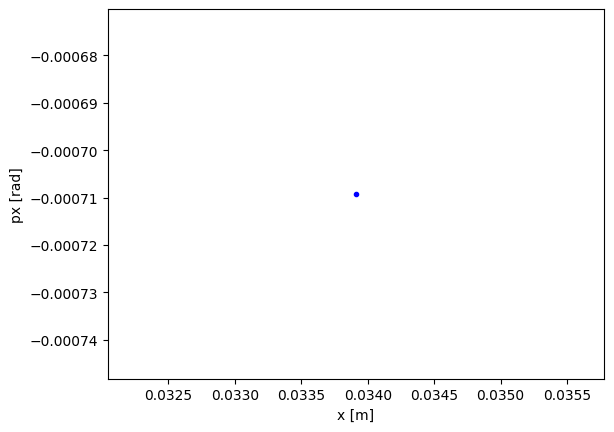

In [10]:
plt.plot(particles.x, particles.px, '.b')
plt.xlabel('x [m]')
plt.ylabel('px [rad]')

In [11]:

plt.figure(figsize=(10, 6))
n = np.arange(0, num_turns)
twiss = line_edited.twiss()
mux = twiss[:,'mymon.*'].mux
betx = twiss[:,'mymon.*'].betx
x_list_all = []
x_list0 = []  
s_list0 = []
x_list_norm = []
mux_all = []
c = 1000*['red', 'green', 'blue', 'black', 'orange', 'yellow', 'pink', 'cyan', 'magenta', 'brown', 'purple', 'gray', 'olive', 'lime', 'teal']
print(len(c))
data_list = []
x_mon = []
x_list_all_app = []
x_list_norm_app = []
s_list_all = []
x_list_clean = []


if True:
    for jj in n:
        x_list = [monitors[ii].x[0,jj] for ii in monitors]   #monitors[ii].x[i,j], i is the particle number, j is the turn number
        mean_x = np.mean(x_list)
        #std_dev = abs(0.1 * mean_x)  # 1% of the mean
        std_dev = 0.001
        noise = np.random.normal(0, std_dev, len(monitor_names))   #white noise generation
       
        x_list_clean.append(x_list)
        x_list = x_list + noise                                    #adding noise to the signal

        #x_list0 = [monitors[ii].x[0,0] for ii in monitors]
        s_list = [monitors[ii].s[0,jj] for ii in monitors]
        x_list_all.extend(x_list)
        x_list_norm.extend(x_list/np.sqrt(betx))
        x_list_all_app.append(x_list)                #transverse x position, not normalized for all turns and bpms
        x_list_norm_app.append(x_list/np.sqrt(betx)) #transverse x position, normalized by the beta function for all turns and bpms


        #print(len(x_list_all))
        mon = monitors['mymon_ip3'].x[0,jj]          #just the first particle, one monitor for all turns, tranverse x position
        mon_position = monitors['mymon_ip3'].s[0,jj] #just the first particle, one monitor for all turns s position (on the ring scaled by the number of turns)
        #mux = twiss[:,'mymon_ip3'].mux
        #print(mux)
        x_list0.append(mon)  
        s_list0.append(mon_position) #
        mux_all.append(mux + mux[-1]*(jj))           #all mux for all turns, one turn all monitors, second turn all monitors, etc
        s_list_all.append(s_list + jj*s_list[-1])    #all s for all turns, one turn all monitors, second turn all monitors, etc
        #plt.plot((s_list + jj*s_list[-1]), x_list, '.-', color=c[jj])
        
        


    
#plt.plot(s_list, x_list0, 1'.-b')
#print(s_list0)

'''
x = np.fft.fft(x_list_all)

plt.xlabel('s [m] x number turn')
plt.ylabel('x [m]')
plt.title('x position of one particle at all BPMs')
print(len(x_list0))
plt.show()

#fft_try = abs(np.fft.fft(x_list0 - np.mean(x_list0)))
fft_try = np.fft.fft(x_list0) # fft of one monitor for all turns
fft_try = fft_try/len(fft_try)*2 #normalization
fft = fft_try.real + 1j*fft_try.imag 
# 
fft_used = abs(fft) - np.mean(abs(fft))
#freq_try = np.fft.fftfreq(len(fft_used), d = 1/len(fft_used))
#freq_try = np.fft.fftfreq(len(x_list0), d = 1/len(x_list0))

freq_try  =  np.linspace(0, sampling_frequency, len(fft_used))
'''



15000


"\nx = np.fft.fft(x_list_all)\n\nplt.xlabel('s [m] x number turn')\nplt.ylabel('x [m]')\nplt.title('x position of one particle at all BPMs')\nprint(len(x_list0))\nplt.show()\n\n#fft_try = abs(np.fft.fft(x_list0 - np.mean(x_list0)))\nfft_try = np.fft.fft(x_list0) # fft of one monitor for all turns\nfft_try = fft_try/len(fft_try)*2 #normalization\nfft = fft_try.real + 1j*fft_try.imag \n# \nfft_used = abs(fft) - np.mean(abs(fft))\n#freq_try = np.fft.fftfreq(len(fft_used), d = 1/len(fft_used))\n#freq_try = np.fft.fftfreq(len(x_list0), d = 1/len(x_list0))\n\nfreq_try  =  np.linspace(0, sampling_frequency, len(fft_used))\n"

<Figure size 1000x600 with 0 Axes>

## Example one FFT

(0.0, 100.0)

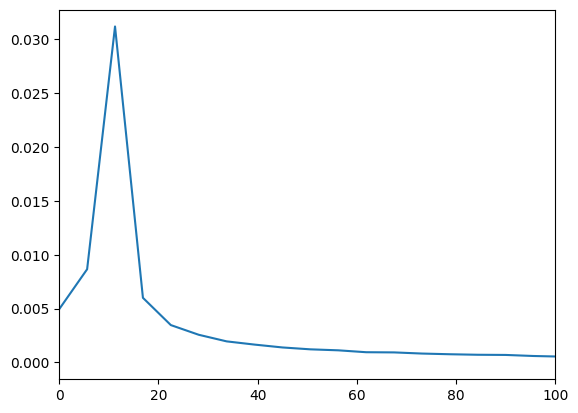

In [12]:
one_fft = np.fft.fft(x_list_all[0::568])
one_fft = one_fft/len(one_fft)*2
one_freq = np.linspace(0, sampling_frequency, len(one_fft))
plt.figure()
plt.plot(one_freq, abs(one_fft))
plt.xlim(0, 100)


## Average the tbt data for each bpm and compute the fft

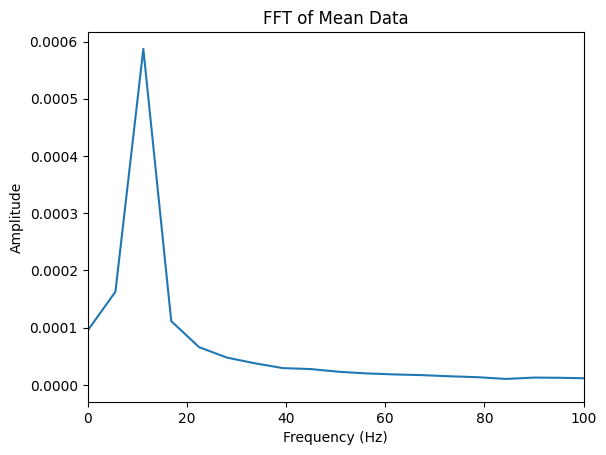

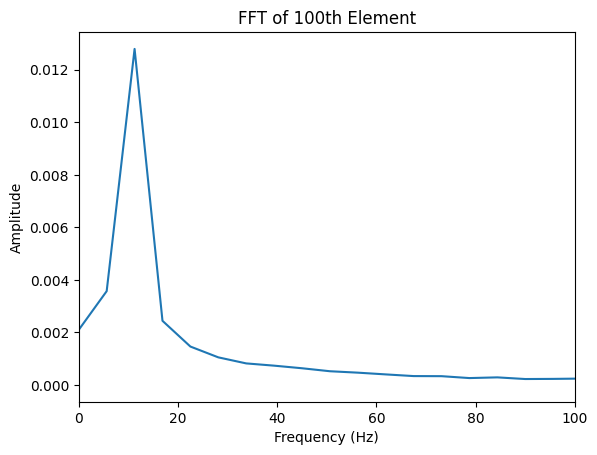

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
STEP = 568
LIMIT_FREQ = 100

def calculate_fft(data):
    fft_result = np.fft.fft(data)
    fft_result = fft_result / len(fft_result) * 2
    freq = np.linspace(0, sampling_frequency, len(fft_result))
    return freq, abs(fft_result)

def plot_fft(freq, fft_result, title, xlim=None):
    plt.plot(freq, fft_result)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title(title)
    if xlim:
        plt.xlim(0, xlim)
    plt.show()

def main():
    # Your data processing logic
    
    x_list_all_avg = [np.mean(x_list_all_app[i::STEP], axis=1) for i in range(2)]
    
    data_list = []
    for i in range(len(monitor_names)):
        data = np.array(x_list_all[i::STEP]).ravel()
        data_list.append(data)

    stacked_data = np.vstack(data_list)

    mean_of_all_elements = np.mean(stacked_data, axis=0)
    freq_mean, fft_mean = calculate_fft(mean_of_all_elements)

    # Plot the FFT
    plot_fft(freq_mean, fft_mean, "FFT of Mean Data", xlim=LIMIT_FREQ)

    # Example plot of the 100th element
    plot_fft(*calculate_fft(data_list[100]), "FFT of 100th Element", xlim=LIMIT_FREQ)

if __name__ == "__main__":
    main()


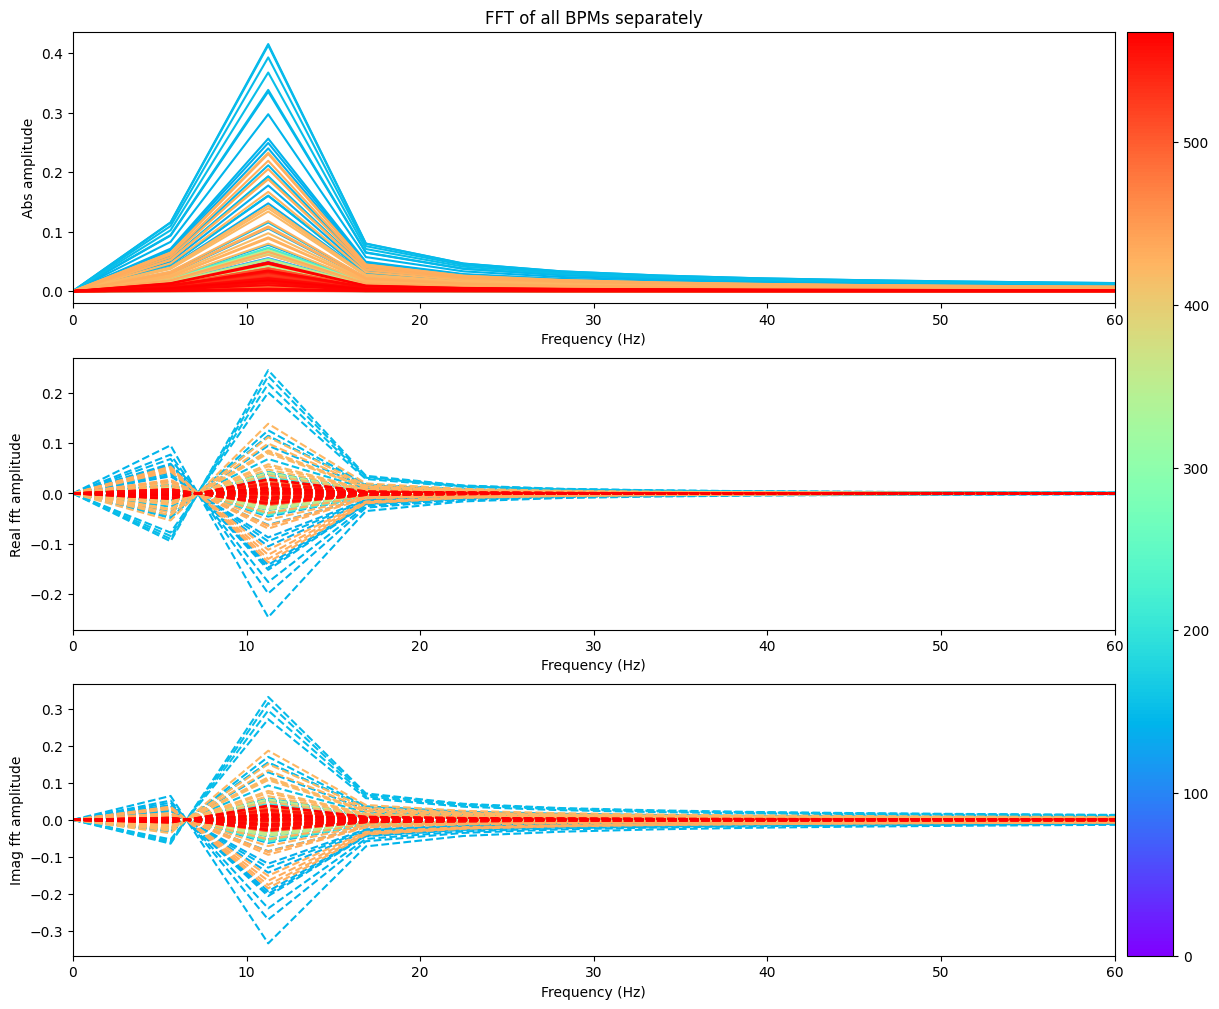

mean of abs complex in the loop 0.03419631242768899
mean of abs complex 0.021649258411112194


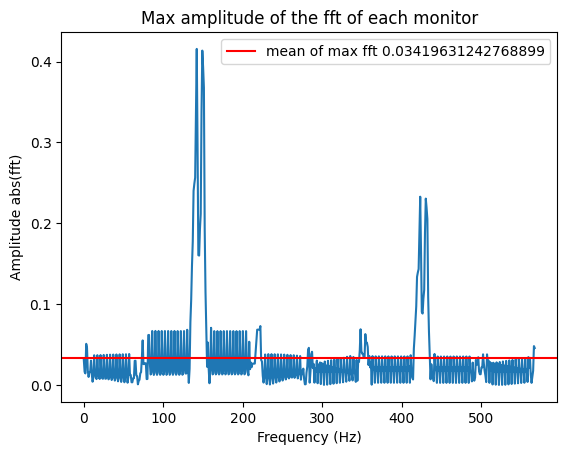

SNR of raw data (transverse position x) = 33.75951924660018 with stdv white noise = 0.001. We compute in order to estimate the closest SNR to the real data


In [14]:
'''
for i in range(num_turns):
    plt.plot(s_list_all[i], x_list_all_app[i])

plt.xlabel('s [m] x number turn')
plt.ylabel('x')
#print(len(mux_all))
'''
from matplotlib.pyplot import cm
color = iter(cm.rainbow(np.linspace(0, 1, len(monitor_names))))

sm = cm.ScalarMappable(cmap=cm.rainbow)
sm.set_clim(0, len(monitor_names))

#freq = np.linspace(0, sampling_frequency, len(fft))

fft_all = []
average_fft = np.zeros(num_turns, dtype=complex)
fft_all_abs = []
average_fft_abs = np.zeros(num_turns)
average_bpm_all = []
max_fft_all = []
max_fft_2_all = []
fig, axs = plt.subplots(3, 1, figsize=(16, 12))

for i in range(len(monitor_names)):
    c = next(color)
    average_bpm = np.mean(x_list_all[i::568])                 #mean of the signal for each bpm
    average_bpm_all.append(average_bpm)
    fft = np.fft.fft(x_list_all[i::568]-np.mean(x_list_all[i::568]))
    fft = fft/len(fft)*2                                      #normalization
    fft = np.round(fft, 6)                              
    freq = np.linspace(0, sampling_frequency, len(fft))
    fft_all.append(fft)
    fft_all_abs.append(abs(fft))
    average_fft_abs = average_fft_abs + abs(fft)                   #just summed up all the abs of the ffts
    #average_fft = np.concatenate((average_fft, fft))
    average_fft  = average_fft + fft                               #just summed up all the complex ffts


    max_fft = np.max(abs(fft))
    max_fft_all.append(max_fft)
    max_fft_2 = np.max(fft)
    max_fft_2_all.append(max_fft_2)
    plt.subplot(3, 1, 1)
    plt.plot(freq, abs(fft), c=c)

    #plt.plot(freq, fft, c=c, linestyle='--')
    plt.xlim(0, 60)
    plt.title('FFT of all BPMs separately')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Abs amplitude')
    plt.subplot(3,1,2)
    plt.plot(freq, fft.real, c=c, linestyle='--')
    plt.xlim(0, 60)
    #plt.title('FFT of all BPMs separately real part')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Real fft amplitude')
    
    plt.subplot(3, 1, 3)
    plt.plot(freq, fft.imag, c=c, linestyle='--')
    plt.xlim(0, 60)
    
    #plt.title('FFT of all BPMs separately imag part')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Imag fft amplitude')
   
cbar = fig.colorbar(sm, ax=axs, orientation='vertical', pad=0.01)
#fig.subplots_adjust(hspace=0.4)  # Adjust the vertical space between subplots

plt.show()

plt.plot(max_fft_all)
plt.axhline(y=np.mean(max_fft_all), color='r', linestyle='-', label=f'mean of max fft {np.mean(max_fft_all)}')
print('mean of abs complex in the loop', np.mean(max_fft_all))
print('mean of abs complex', np.mean(abs(np.array(max_fft_2_all))))      # different than the mean of the max of the abs since
                                                                         # adding complex numbers and adding abs numbers are different!!!
plt.title('Max amplitude of the fft of each monitor')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude abs(fft)')
plt.legend()
plt.show()
# Raw singnal SNR
"""
signal_power_raw = np.mean(np.abs(x_list_clean) ** 2)
signal_power_raw_noisy = np.mean(np.abs(x_list_all) ** 2)
SNR_raw = signal_power_raw / abs(signal_power_raw_noisy - signal_power_raw)
"""
# Calculate the power of the clean signal (without noise)
signal_power_raw = np.mean(np.abs(x_list_clean) ** 2)


# Calculate the power of the noisy signal (including both signal and noise)
signal_power_raw_noisy = np.mean(np.abs(x_list_all) ** 2)

# Calculate the noise power as the difference between the two
noise_power = signal_power_raw_noisy - signal_power_raw

# Calculate SNR in decibels (dB)
SNR_raw = 10 * np.log10(signal_power_raw / noise_power)

print(f'SNR of raw data (transverse position x) = {SNR_raw} with stdv white noise = {std_dev}. We compute in order to estimate the closest SNR to the real data')

plt.show()



max 0.3334968522565098
max avg_abs 19.42236444275553
58.2385240260582
0.3334968522565098
19.42236444275553


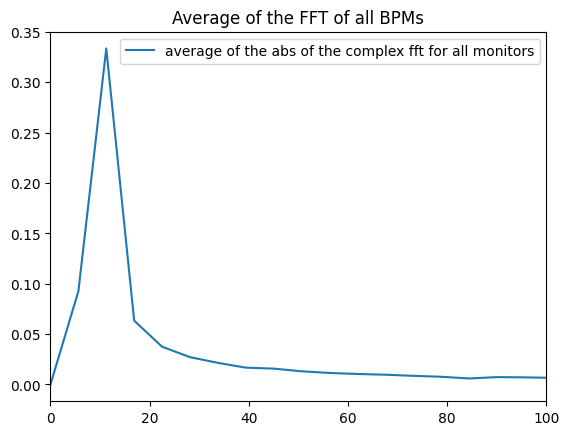

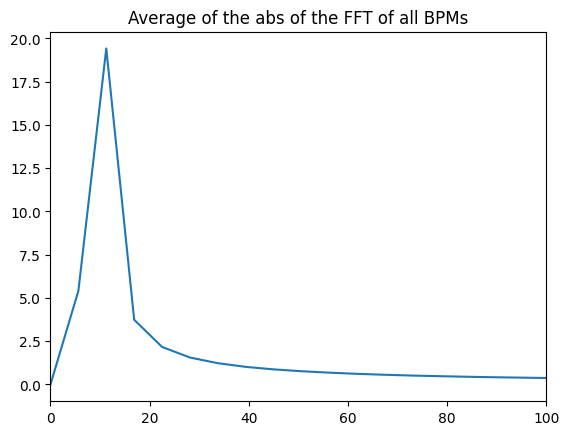

In [32]:

abs_avg = abs(average_fft)

print('max', np.max(abs_avg))


plt.plot(freq, abs_avg, label = 'average of the abs of the complex fft for all monitors')
plt.title('Average of the FFT of all BPMs')
#plt.plot(one_freq, abs(one_fft), label = 'FFT of one monitor for all turns')
#plt.xlim(0,1000)
plt.legend()
#average_fft /= len(monitor_names)
plt.xlim(0, sampling_frequency/2)
plt.xlim(0,100)
#average of the abs of the complex fft for all monitors

plt.figure()
avg_abs = 0
avg_abs = average_fft_abs
print('max avg_abs', np.max(avg_abs))

plt.title('Average of the abs of the FFT of all BPMs')
plt.plot(freq, avg_abs, label = 'average of the abs of the complex fft for all monitors')
plt.xlim(0,100)
#plt.xlim(0, sampling_frequency/2)
#plt.plot(freq, abs(fft_mean))
#plt.plot(x_list_all[0::568])
print(1/(np.max(abs_avg)/np.max(avg_abs)))
print(np.max(abs_avg))
print(np.max(avg_abs))
#1/(np.max(abs_avg)/np.max(avg_abs))


In [16]:
len(average_fft_abs)

2000

max abs_avg 19.42236444275553


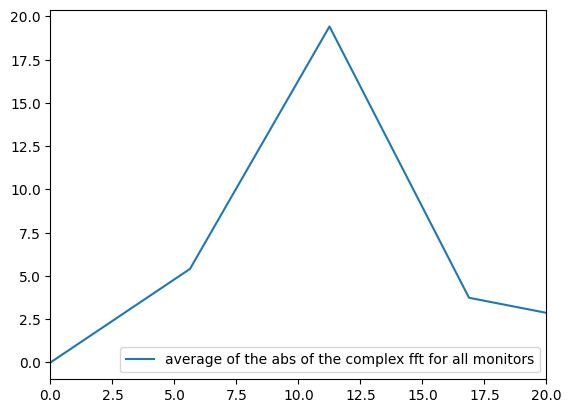

In [17]:

#plt.plot(freq, abs_avg, label = 'abs of the average of the complex fft for all monitors')
plt.plot(freq, avg_abs, label = 'average of the abs of the complex fft for all monitors')
plt.legend()
(np.max(abs_avg)-np.max(avg_abs))
plt.xlim(0,20)
print('max abs_avg', np.max(avg_abs))

Text(0, 0.5, 'x / $\\sqrt{betx}$')

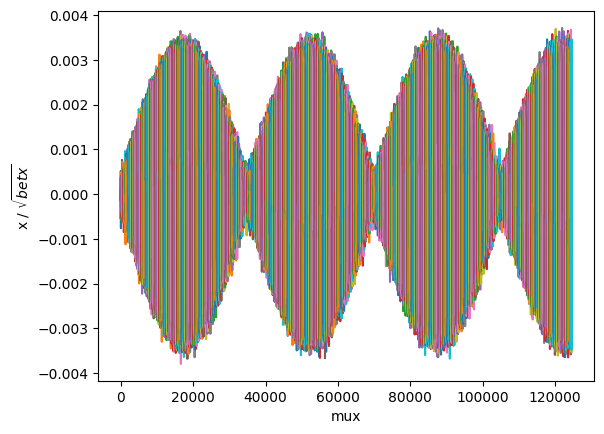

In [18]:
for i in range(len(mux_all)):
    plt.plot(mux_all[i], x_list_norm_app[i])

plt.xlabel('mux')
plt.ylabel('x / $\sqrt{betx}$')
#print(len(mux_all))

In [19]:
import pandas as pd

# Create lists to store monitor-specific data
x_mon_list = []
x_mon_norm_list = []
bpm_names_list = []

# Iterate through monitor names
#for monitor_name in monitor_names:
for monitor_name in range(len(monitor_names)):
    x_mon = [monitors[monitor_names[monitor_name]].x[0, jj] for jj in n]  # Collect data for all 'jj' values at once
    x_mon_norm = [x / np.sqrt(betx[monitor_name]) for x in x_mon]  # Normalize data for all 'jj' values at once

    # Append the data to the respective lists
    x_mon_list.extend(x_mon)
    x_mon_norm_list.extend(x_mon_norm)
    bpm_names_list.extend([monitor_names[monitor_name]] * len(n))

    # Your plotting code
    # ...

# Create a DataFrame from the collected data
data = pd.DataFrame({
    'bpm_names': bpm_names_list,
    'x_list_all': x_mon_list,
    'x_list_norm': x_mon_norm_list
})

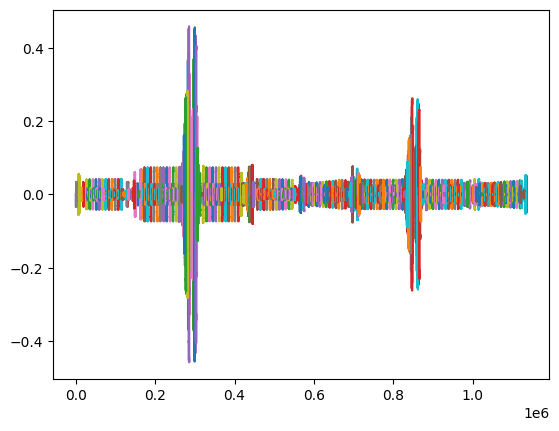

In [20]:
data.groupby('bpm_names')

for key, group in data.groupby('bpm_names'):
    plt.plot(group.x_list_all, label=key)


first = data[data['bpm_names'] == 'mymon_ip3']


print(first['x_list_all'])

plt.plot(first['x_list_all'])

bpm1 = first['x_list_all']
bpm1_norm = data.groupby('bpm_names')

print(bpm1_norm)

first_fft = np.fft.fft(first['x_list_all'])/len(first['x_list_all'])*2
first_freq = np.fft.fftfreq(len(first_fft), d=1/sampling_frequency)


zero_padding_factor = 10
fft_try_first = np.fft.rfft(bpm1-np.mean(bpm1), n = len(bpm1) * zero_padding_factor)
#print(len(fft_try))
# Normalize the FFT result
fft_normalized_first = fft_try_first / len(bpm1)*2
freq_try_first = np.fft.rfftfreq(len(bpm1) *  zero_padding_factor, d=1/sampling_frequency)
#print(len(freq_try))


# Calculate the amplitude spectrum
fft_amplitude = np.abs(fft_normalized_first)
plt.show()


plt.show()
plt.plot(first_freq, abs(first_fft))
plt.plot(freq_try_first, fft_amplitude, '-.')
plt.xlim(0, 30)

#for i in range(len(monitor_names)):


    

    
    

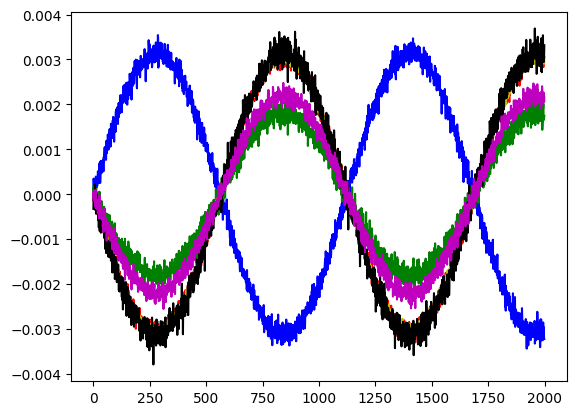

In [31]:
plt.plot(x_list_norm[500::568], '-b')
plt.plot(x_list_norm[0::568], '-r')
plt.plot(x_list_norm[100::568], '-g')
plt.plot(x_list_norm[200::568], '-y')
plt.plot(x_list_norm[300::568], '-k')
plt.plot(x_list_norm[400::568], '-m')
plt.show()

#for i in range(np.arange(len(num_turns))):
for i in range(3):
    x_list_norm[i*568:(i+1)*568]
    #print(len(x_list_norm[i*568:(i+1)*568]))
    #print(len(mux_all[i*568:(i+1)*568]))
    #plt.plot(mux_all[i*568:(i+1)*568],x_list_norm[i*568:(i+1)*568], '-')

plt.show()


#What is that phase change???

grouped = data.groupby('bpm_names')

In [22]:
#for bpm in monitor_names:
    #print(data['bpm_names']==bpm)
    #print(data[data['bpm_names']==bpm]['x_list_all'])
    #plt.plot(mux_all[bpm],data[data['bpm_names']==bpm]['x_list_norm'])


data.groupby('bpm_names')

#for name, group in grouped:
    #print(name)  # The group's name (based on the column you grouped by)
    #print(group)  # The data in the group

group_names = grouped.groups.keys()
for group_name in group_names:
    group_indices = grouped.groups[group_name]
    specific_group = data.loc[group_indices]
    #print(group_name)
    print(specific_group)

1136000


,0
0,0.000682
1,-0.000043
2,-0.001852
3,-0.000457
4,0.001940
...,...
1135995,0.000120
1135996,0.010661
1135997,0.018416
1135998,0.051837


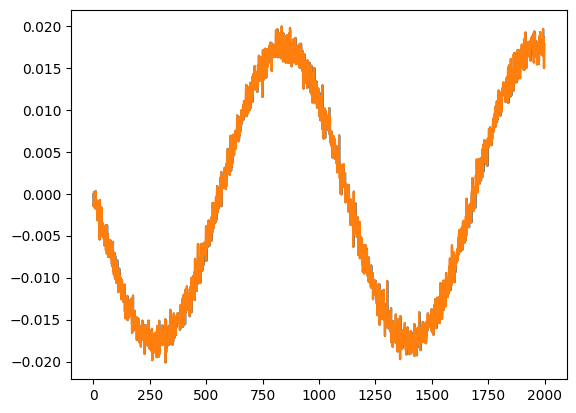

In [ ]:
mux_all_flat = np.array(mux_all).reshape(-1,1)
print(len(x_list_norm))
import pandas as pd

plt.plot(x_list_all[1::568])
x_pos_all = pd.DataFrame(x_list_all)

plt.plot(x_list_all[569*10::568])
display(x_pos_all)


(0.0, 20.0)

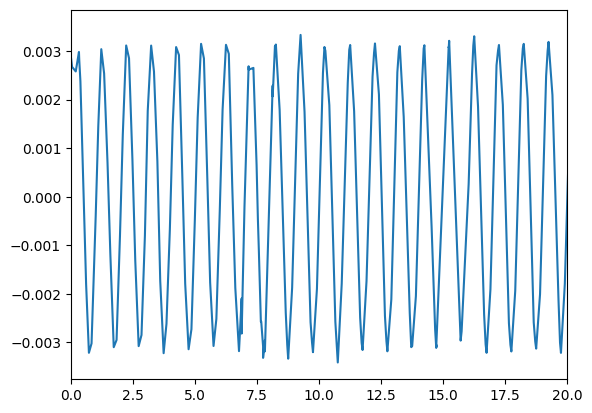

In [ ]:
len(x_list/np.sqrt(betx))
plt.plot(mux, x_list/np.sqrt(betx))
plt.xlim(0,20)

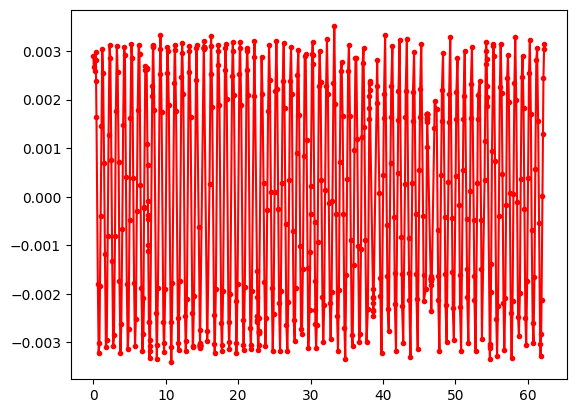

In [ ]:
plt.plot(mux, x_list/np.sqrt(betx), '.-r')

Text(0, 0.5, 'x [m]')

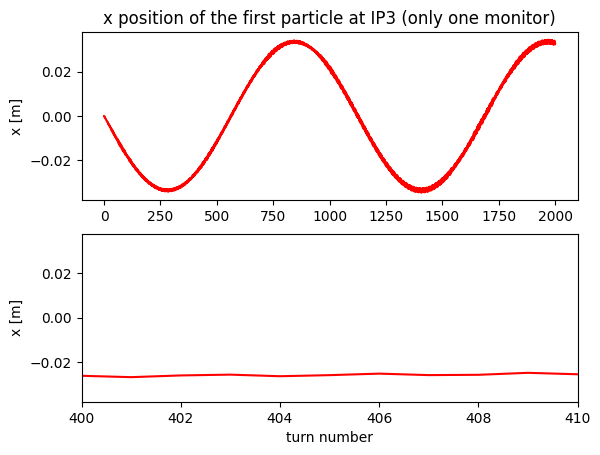

In [ ]:
plt.subplot(2,1,1)
plt.title('x position of the first particle at IP3 (only one monitor)')
plt.plot(np.arange(num_turns), x_list0, '-r') 
plt.ylabel('x [m]')
plt.subplot(2,1,2)
plt.plot(np.arange(num_turns), x_list0, '-r')
plt.xlim(400, 410)
plt.xlabel('turn number')
plt.ylabel('x [m]')


amplitude_fit 0.0010612836040554796
frequency_fit 0.9998725394875645


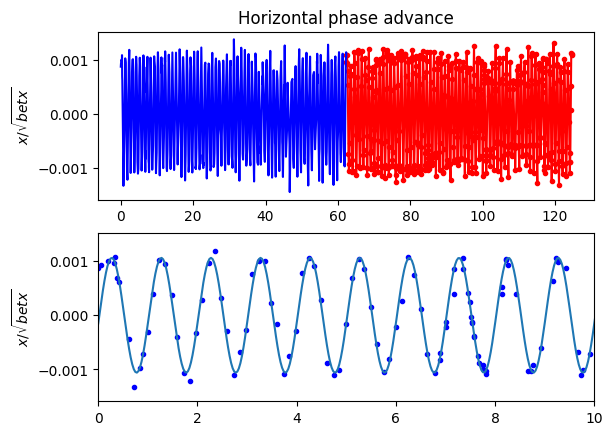

In [29]:
# Data for only the first turn, all BPMs
#print('betx', betx)
#y_data = x_list_all[len(mux)+1:len(mux)*2+1]/np.sqrt(betx)
#y_data_1 = x_list_all[0:len(mux)]/np.sqrt(betx)
mux = twiss[:,'mymon.*'].mux
n= -100

#y_data_1 = x_list_all[len(mux)*int(num_turns/2+2):len(mux)*int(num_turns/2+3)]/np.sqrt(betx)
#y_data = x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx)
#y_data_0 = x_list_all[len(mux)*int(num_turns/2+0):len(mux)*int(num_turns/2+1)]/np.sqrt(betx)
y_data_0 = x_list_all[len(mux)*int(721+n):len(mux)*int(722+n)]/np.sqrt(betx)
y_data = x_list_all[len(mux)*int(722+n):len(mux)*int(723+n)]/np.sqrt(betx)
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + offset

# Fit the sine function to the data
initial_guess = [1, 1, 0, 1]  # Initial guess for the parameters
fit_params, _ = curve_fit(sine_function, mux, y_data_0, p0=initial_guess)
fit_params1, _1 = curve_fit(sine_function, mux, y_data, p0=initial_guess)
# Extract the fitted parameters
amplitude_fit, frequency_fit, phase_fit, offset_fit = fit_params
amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1 = fit_params1

x_fine = np.linspace(min(mux), 2 * max(mux), 4000)
# Generate the fitted curve using the fitted parameters
y_fit = sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit)
y_fit1 = sine_function(x_fine, amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1)

fitted_sine_interpolated = interp1d(x_fine, sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit))
fitted_sine_interpolated1 = interp1d(x_fine, sine_function(x_fine, amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1))
y_fine = fitted_sine_interpolated(x_fine)
y_fine_1 = fitted_sine_interpolated1(x_fine)

y_fit = sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit)
plt.subplot(2,1,1)

#plt.plot(mux, x_list_all[0:len(mux)]/np.sqrt(betx), '.-r')
plt.plot(mux+mux[-1], y_data, '.-r')
plt.plot(mux, y_data_0, '-b')
#plt.plot(mux+2*mux[-1], y_data_1, '.-g')
#plt.plot(x_fine, y_fine)
#plt.xlim(0,10)
#plt.plot(mux, x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx), '.-r')
#plt.plot(x_fine,y_fine, '-b')
plt.title('Horizontal phase advance')
plt.ylabel('$x/\sqrt{betx}$')
plt.subplot(2,1,2)
#plt.plot(mux, x_list_all[0:len(mux)]/np.sqrt(betx), '.-r')
#plt.plot(mux, y_data, '.-r')#
plt.plot(mux + mux[-1], y_data, '.r')
plt.plot(mux, y_data_0, '.b')
plt.plot(x_fine, y_fine)
plt.plot(x_fine+x_fine[-1]/2, y_fine_1)
#plt.plot(mux+2*mux[-1], y_data_1, '.-g')
#plt.plot(mux, x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx), '.-r')
#plt.plot(x_fine,y_fine, '-b')
#plt.xlim(mux[-1]*2-mux[10], mux[-1]*2+ mux[10])
#plt.xlim(61.7, 64)
plt.xlim(0,10)
#print('mux', twiss[:,'mymon.*'].mux)
#print('len mux', len(twiss[:,'mymon.*'].mux)))
plt.ylabel('$x/\sqrt{betx}$')
print('amplitude_fit', amplitude_fit)
print('frequency_fit', frequency_fit)



# Localization of the broken phase
 - One can find a period where the phase is not broken and fit the function, then one extends the fit for all the data and looks where the error grows.
 - Due to the small number of data points (BPMs) a more fine grid is implemented and the closest phase value localized.
 - This value is then compared to the horizontal displacement and the fit horizontal displacement without a broken phase
 - Clearly the breaking in the phase can be seen exactly as expected

Text(0, 0.5, '$x/\\sqrt{betx}$ - $x_{fit}$')

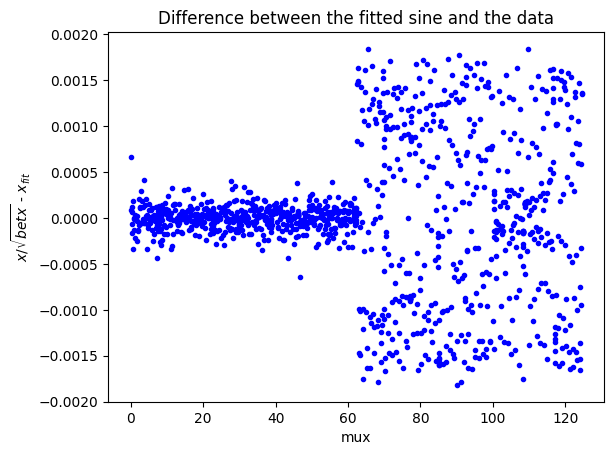

In [30]:
#% find the closest x_fine value to mux



closest_ind_all = []
x_close_all = []
y_close_all = []
y_diff = []
y_diff0 = []
mux = twiss[:,'mymon.*'].mux
mux = np.append(mux, mux + mux[-1])
for i in range(len(mux)):
    y_close = []
    closest_ind = []
    x_close = []
    closest_ind = np.argmin(np.abs(x_fine - (mux[i])))
    closest_ind_all.append(closest_ind)
    x_close = x_fine[closest_ind]
    x_close_all.append(x_close)
    y_close = y_fine[closest_ind]
    y_close_all.append(y_close)
    
y_diff_all = []
y_diff = y_data - y_close_all[len(y_data):]
y_diff0 = y_data_0 - y_close_all[:len(y_data)]
y_diff_all = np.append(y_diff0, y_diff)
    
#print('closest_ind_all', closest_ind_all)
#print('y_close', y_close_all)
#print(len(y_close_all))



#print('y_diff', y_diff[:20])
#print('y_diff0', y_diff0[:20])
#print(len(closest_ind_all))
#print(len(mux))
for i in range(len(y_diff_all)):
    if i > 1e-10:
        plt.plot(mux[i], y_diff_all[i], '.b')
plt.title('Difference between the fitted sine and the data')
plt.xlabel('mux')
plt.ylabel('$x/\sqrt{betx}$ - $x_{fit}$')



# Phase advance between the signals

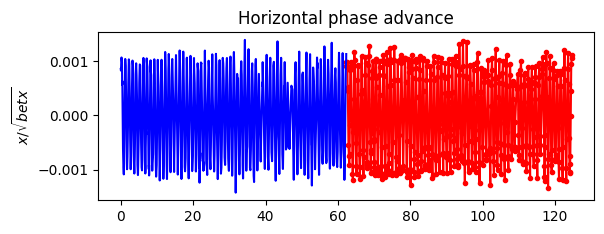

amplitude_fit 0.0010574148202347068
frequency_fit 0.9997611677555525
-0.09995345730517427


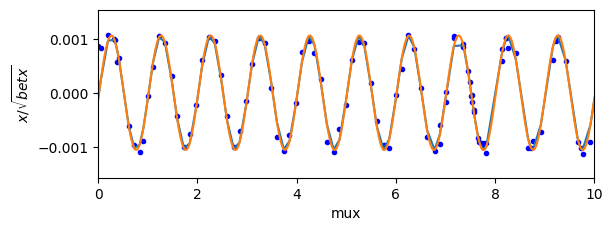

In [ ]:
# Data for only the first turn, all BPMs
#print('betx', betx)
#y_data = x_list_all[len(mux)+1:len(mux)*2+1]/np.sqrt(betx)
#y_data_1 = x_list_all[0:len(mux)]/np.sqrt(betx)
mux = twiss[:,'mymon.*'].mux
n= -100

#y_data_1 = x_list_all[len(mux)*int(num_turns/2+2):len(mux)*int(num_turns/2+3)]/np.sqrt(betx)
#y_data = x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx)
#y_data_0 = x_list_all[len(mux)*int(num_turns/2+0):len(mux)*int(num_turns/2+1)]/np.sqrt(betx)
y_data_0 = x_list_all[len(mux)*int(721+n):len(mux)*int(722+n)]/np.sqrt(betx)
y_data = x_list_all[len(mux)*int(722+n):len(mux)*int(723+n)]/np.sqrt(betx)
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
def sine_function(x, amplitude, frequency, phase, offset):
    return amplitude * np.sin(2 * np.pi * frequency * x + phase) + offset

# Fit the sine function to the data
initial_guess = [1, 1, 0, 1]  # Initial guess for the parameters

fit_params, _ = curve_fit(sine_function, mux, y_data_0, p0=initial_guess)
fit_params1, _1 = curve_fit(sine_function, mux, y_data, p0=initial_guess)
# Extract the fitted parameters
amplitude_fit, frequency_fit, phase_fit, offset_fit = fit_params
amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1 = fit_params1

x_fine = np.linspace(min(mux),  max(mux), 100000)
# Generate the fitted curve using the fitted parameters

y_fit_data = sine_function(mux, amplitude_fit, frequency_fit, phase_fit, offset_fit)
y_fit = sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit)
y_fit1 = sine_function(x_fine, amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1)

#fitted_sine_interpolated_data = interp1d(mux, sine_function(mux, amplitude_fit, frequency_fit, phase_fit, offset_fit))
fitted_sine_interpolated = interp1d(x_fine, sine_function(x_fine, amplitude_fit, frequency_fit, phase_fit, offset_fit))
fitted_sine_interpolated1 = interp1d(x_fine, sine_function(x_fine, amplitude_fit1, frequency_fit1, phase_fit1, offset_fit1))

#y_notfine = fitted_sine_interpolated_data(mux)
y_fine = fitted_sine_interpolated(x_fine)
y_fine_1 = fitted_sine_interpolated1(x_fine)


plt.subplot(2,1,1)

#plt.plot(mux, x_list_all[0:len(mux)]/np.sqrt(betx), '.-r')
plt.plot(mux+mux[-1], y_data, '.-r')
plt.plot(mux, y_data_0, '-b')
#plt.plot(mux+2*mux[-1], y_data_1, '.-g')
#plt.plot(x_fine, y_fine)
#plt.xlim(0,10)
#plt.plot(mux, x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx), '.-r')
#plt.plot(x_fine,y_fine, '-b')
plt.title('Horizontal phase advance')
plt.ylabel('$x/\sqrt{betx}$')
plt.show()
plt.subplot(2,1,2)
#plt.plot(mux, x_list_all[0:len(mux)]/np.sqrt(betx), '.-r')
#plt.plot(mux, y_data, '.-r')#
plt.plot(mux + mux[-1], y_data, '.r')
plt.plot(mux, y_data_0, '.b')
plt.plot(mux, y_fit_data)
plt.plot(x_fine, y_fine)
plt.plot(x_fine+x_fine[-1], y_fine_1)
#plt.plot(mux+2*mux[-1], y_data_1, '.-g')
#plt.plot(mux, x_list_all[len(mux)*int(num_turns/2+1):len(mux)*int(num_turns/2+2)]/np.sqrt(betx), '.-r')
#plt.plot(x_fine,y_fine, '-b')
#plt.xlim(mux[-1]*2-mux[10], mux[-1]*2+ mux[10])
#plt.xlim(61.7, 64)
plt.xlim(0,10)
#print('mux', twiss[:,'mymon.*'].mux)
#print('len mux', len(twiss[:,'mymon.*'].mux))
#print('twiss.mux', len(twiss.mux))

plt.xlabel('mux')
plt.ylabel('$x/\sqrt{betx}$')
print('amplitude_fit', amplitude_fit)
print('frequency_fit', frequency_fit)
print(phase_fit)





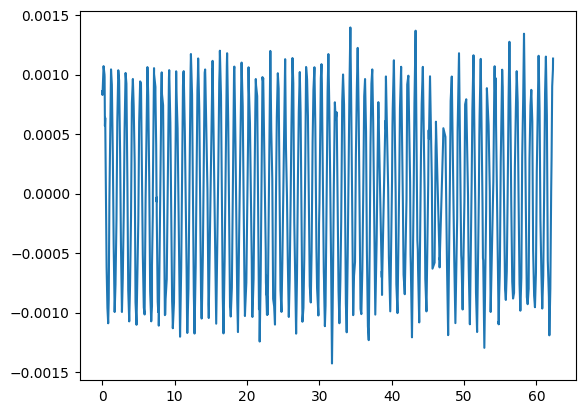

In [ ]:
turn_0 = y_data_0
turn_1 = y_data

mux = twiss[:,'mymon.*'].mux 
plt.plot(mux, turn_0)
#plt.plot(mux, turn_1)

#plt.plot(turn_1)
#plt.xlim([100,150])

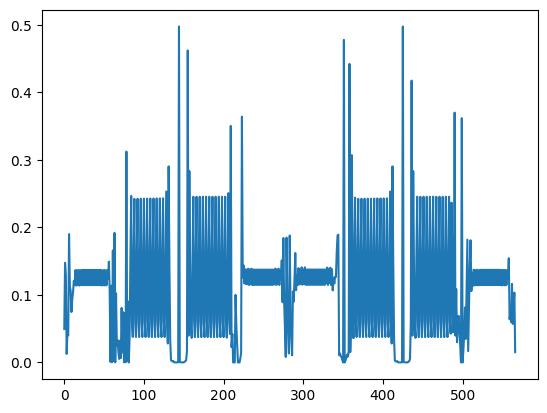

In [ ]:
plt.plot(np.diff(twiss[['mux'],'mymon_.*']))

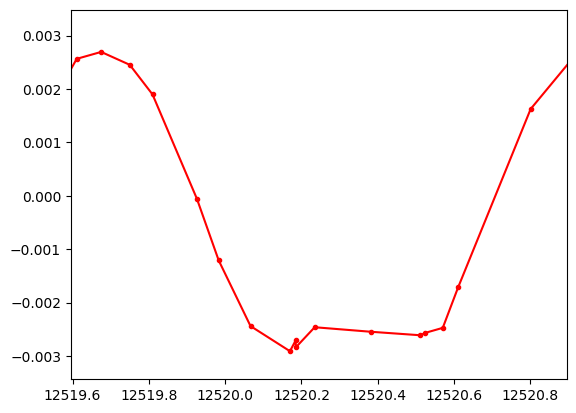

In [27]:
mux_all_list = []
for i in range(num_turns):
    mux_all = mux + i*mux[-1]
    mux_all_list = np.append(mux_all_list, mux_all)
number = 200
#print(len(mux_all_list))
used_x = np.array(x_list_norm[len(mux)*number:len(mux)*(number+2)])/1
used_mux = np.array(mux_all_list[len(mux)*number:len(mux)*(number+2)])/1
#print(mux_all_list[550:600])
data = np.stack((mux_all_list, x_list_norm))
#print(data.T[55000:60000])
plt.plot(used_mux, used_x, '.-r')

plt.xlim(mux_all_list[len(mux)*number]+61.7, mux_all_list[len(mux)*(number)]+63)
#plt.xlim(40250.7, 40300)
#plt.ylim(-0.5e-8, 0.5e-8)
plt.show()

The 10 Hz is now -11.2455


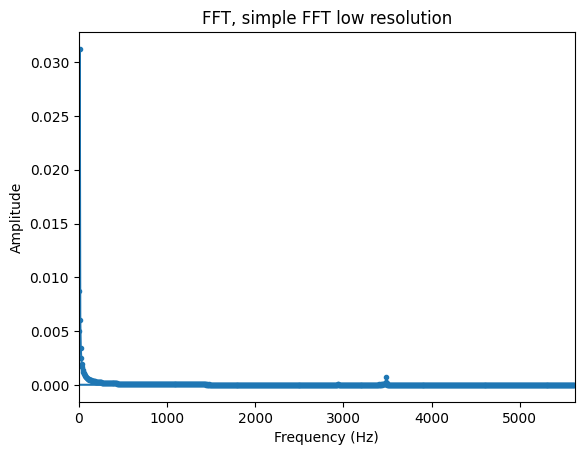

In [ ]:
fft_try = np.fft.fft(x_list0)

# Normalize the FFT result
fft_normalized = fft_try / len(fft_try)*2

# Calculate the frequency axis
sampling_frequency = 11245.5 # Adjust this to match your actual sampling frequency
freq_try = np.fft.fftfreq(len(fft_normalized), d=1/sampling_frequency)


# Calculate the amplitude spectrum
fft_amplitude = np.abs(fft_normalized)


# Plot the frequency spectrum
plt.plot(freq_try, fft_amplitude, '.-')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT, simple FFT low resolution")
plt.xlim(0, sampling_frequency / 2)  # Nyquist frequency
#plt.xlim(0,20)

#print('The tune is', freq_try[np.argmax(fft_amplitude)]/sampling_frequency)
print('The 10 Hz is now', freq_try[np.argmax(fft_amplitude)])
plt.show()

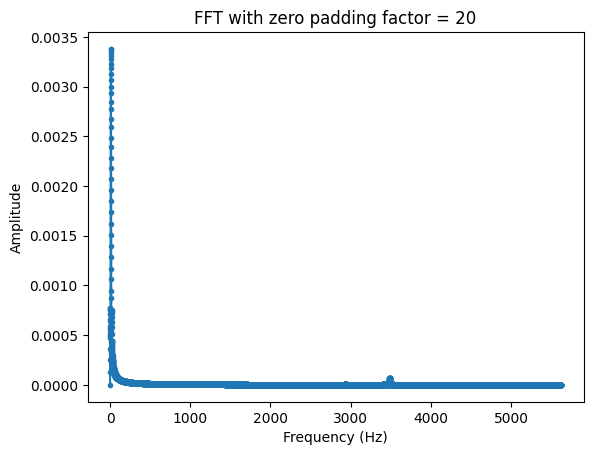

10 Hz 10.120949999999999


In [ ]:
# Zero padding
zero_padding_factor = 20
fft_try = np.fft.rfft(x_list0-np.mean(x_list0), n = len(x_list0) * zero_padding_factor)
#print(len(fft_try))
# Normalize the FFT result
fft_normalized = fft_try / len(fft_try)*2

# Calculate the frequency axis
sampling_frequency = 11245.5 # Adjust this to match your actual sampling frequency
freq_try = np.fft.rfftfreq(len(x_list0) *  zero_padding_factor, d=1/sampling_frequency)
#print(len(freq_try))


# Calculate the amplitude spectrum
fft_amplitude = np.abs(fft_normalized)
#print(fft_amplitude)


# Plot the frequency spectrum
plt.plot(freq_try, fft_amplitude, '.-')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("FFT with zero padding factor = 20")
#plt.xlim(0.22, 0.4)  # Nyquist frequency
#plt.xlim(0,20)  
plt.show()
#print('The tune is', freq_try[np.argmax(fft_amplitude)]/sampling_frequency)
print('10 Hz', freq_try[np.argmax(fft_amplitude[0:1000])])

In [ ]:
twiss.dqx 

-352.71085168247396

[0.00000000e+00 8.89244587e-05 1.77848917e-04 ... 8.88977813e-01
 8.89066738e-01 8.89155662e-01]
-100


"\ntotal_time = n_turns / f_rev\ntime = np.arange(0, total_time, 1/sampling_freq)\nsamples = np.sin(2*np.pi*f_ex*time + phi)\n\n\nexciter = xt.Exciter(_context = ctx,\n    samples = samples,\n    sampling_frequency = sampling_freq,\n    duration = None,  # defaults to waveform duration\n    frev = f_rev,\n    start_turn = 0,  # default, seconds\n    knl = KNL,\n    ksl = KSL,\n)\n\n# Add it to the line for tracking as usual\nline.insert_element(\n    element = exciter,\n    name = 'RF_KO_EXCITER',\n    index = 42,\n)\n\ninsertion of the element in the beamline, the phase should be broken due to the kick\n"

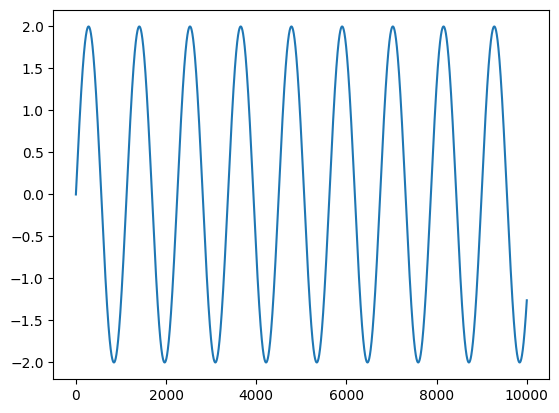

In [ ]:
# Kick - a wave that is applied to the signal periodically, we choose a sine wave
phi = 0
f = 10 # Hz
A = 2
t = np.arange(10000)/sampling_frequency  # n = 10000, should be 50 in this case, but then the resolution is too low res =  sampling_frequency / frequency
print(t)
#t = np.linspace(0, 1, 50)
print(n)
kick = A * np.sin(2*np.pi*f*t + phi)
plt.plot(np.arange(10000), kick)

# example of a kick
'''
total_time = n_turns / f_rev
time = np.arange(0, total_time, 1/sampling_freq)
samples = np.sin(2*np.pi*f_ex*time + phi)


exciter = xt.Exciter(_context = ctx,
    samples = samples,
    sampling_frequency = sampling_freq,
    duration = None,  # defaults to waveform duration
    frev = f_rev,
    start_turn = 0,  # default, seconds
    knl = KNL,
    ksl = KSL,
)

# Add it to the line for tracking as usual
line.insert_element(
    element = exciter,
    name = 'RF_KO_EXCITER',
    index = 42,
)

insertion of the element in the beamline, the phase should be broken due to the kick
'''


#collider.build_trackers()
betx = twiss['betx'][0]
bety = twiss['bety'][0]
normal_emitt_x = 2.5e-6
normal_emitt_y = 2.5e-6

sigma_x = np.sqrt(betx*normal_emitt_x/(particles.gamma0*particles.beta0))[0]
sigma_y = np.sqrt(bety*normal_emitt_y/(particles.gamma0*particles.beta0))[0]
x = np.linspace(sigma_x, 3*sigma_x, 5)
px = np.zeros(5)
y = np.zeros(5)
py = np.zeros(5)
zeta = np.zeros(5)
delta = np.zeros(5)

particles = xp.Particles(
                    mass0=xp.PROTON_MASS_EV, q0=1, energy0=7000e9, x=x)

collider['lhcb1'].track(particles, num_turns=num_turns,
              turn_by_turn_monitor=True)

print(x)

ys = collider['lhcb1'].record_last_track.y
xs = collider['lhcb1'].record_last_track.x
print(xs)
qx_i = []
qy_i = []
for ii in range(len(x)):
    qx_i.append(PyNAFF.naff(xs[ii,:], turns=499)[0][1])
    qy_i.append(PyNAFF.naff(ys[ii,:], turns=499)[0][1])

fig, ax = plt.subplots(figsize=(10, 10))
#plt.plot(qx_i,qy_i,'-o')
plt.plot(x**2/sigma_x**3,qx_i,'-o')
plt.xlabel(r'$x^{2}$[$\sigma^{2}$]', size = 20)
#plt.xlabel(r'qx', size = 20)

plt.ylabel(r'qx', size = 20)
plt.grid()

array([12.0889125])

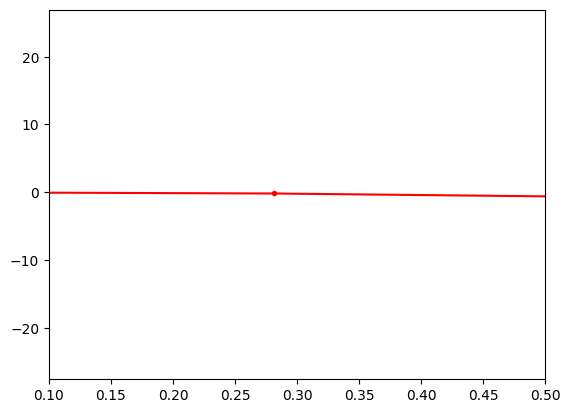

In [ ]:
# 50 turns, tune -.37, reference value is -0.352
plt.plot(freq_try, fft_try, '.-r')
plt.xlim(0.1, 0.5)
# find the tune
twiss = line_edited.twiss()
twiss.dqx
ind = np.where(fft_try==np.max(fft_try))
fft_try[ind]
freq_try[ind]


568


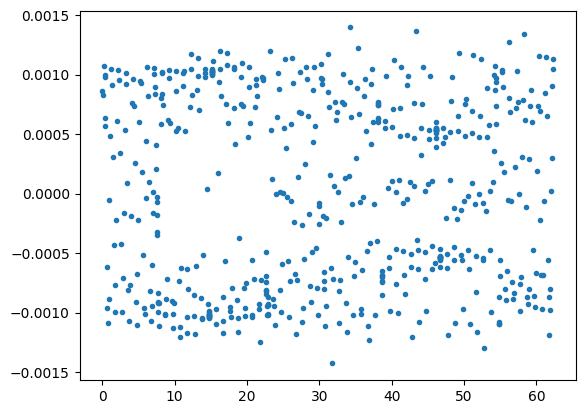

In [ ]:
turn_0 = y_data_0
turn_1 = y_data
print(len(turn_0))
mux = twiss[:,'mymon.*'].mux 
#x=mux[10:30]
#y=turn_0[10:30]
x = mux
y = turn_0

plt.plot(x,y,'.')
#plt.plot(mux, turn_1)


In [25]:
mux_all_flat1 = mux_all_flat.ravel()
print(np.array(mux_all_flat1))

NameError: name 'mux_all_flat' is not defined

In [26]:
# find th sine wave that fits the data y = a*sin(2*pi*f*x + phi)
# find the phase advance for the first turn

mux_all_flat1 = mux_all_flat1[:4000].flatten()
x_list_norm = x_list_norm[:4002]
def my_fit(i, A, phi):
    return A*np.sin(2*np.pi*i + phi)

def sine_function(x, amplitude, phase):
    return amplitude * np.sin(2 * np.pi  * x + phase) 
x_0 = x - x[0]
print(x_0)

number_bpms = 150
# Fit the sine function to the data
initial_guess = [1e-8,  0]  # Initial guess for the parameter
my_phase = []
for start_bpm in range(len(mux_all_flat1)-number_bpms):
    #x=mux[(0+start_bpm):(20+start_bpm)]
    #y=turn_0[(0+start_bpm):(20+start_bpm)]
    x=mux_all_flat1[(0+start_bpm):(number_bpms+start_bpm)]
    y=x_list_norm[(0+start_bpm):(number_bpms+start_bpm)]

    #x_0 = x - x[0]
    #print(x_0)
    #my_fit = [my_fit(i, 1.05892633e-08,-1.63081640e-01) for i in x]
    # plt.plot(x_0, my_fit)
    # plt.plot(x_0,y,'.r')


    fit_params, _ = curve_fit(sine_function, x, y, p0=initial_guess, maxfev = 1000000)
    my_phase.append(fit_params[1])
    #print(fit_params[1])
    #plot the verticle line where the new turn starts
    #plt.axvline(, linestyle='dashed')
rounded_phases = np.round(np.array(my_phase), 4)  # Round to a reasonable precision, corrects for numerical noise
mod_pi_phases = rounded_phases % np.pi


#plt.axhline(y=1/2, linestyle='dashed')
#plt.axhline(y=-1/2, linestyle='dashed')
plt.plot(mux_all_flat1[:-number_bpms-1], abs(np.diff(mod_pi_phases)), '.', label = 'phase advance')

plt.xlabel('mux')
plt.axhline(y = np.pi, label = '$\pi$', linestyle='dashed')
plt.ylabel('$\Delta$ phase advance mod $\pi$')
#print(my_phase)
#plt.plot(x_0, y, '.-r')
plt.autoscale(enable=True)
unique_labels = set()



for i in range(8):
    color = 'orange'
    label = 'starting new turn'

    plt.axvline(x=mux[-1] * i, color=color, linestyle='dashed', label=label)

    # Add the label to the set to ensure it's only displayed once in the legend
    unique_labels.add(label)

# Create a custom legend with unique labels
handles, labels = plt.gca().get_legend_handles_labels()
unique_handles = []
unique_labels = []
for handle, label in zip(handles, labels):
    if label not in unique_labels:
        unique_labels.append(label)
        unique_handles.append(handle)
plt.xlim(0,500)
plt.legend(unique_handles, unique_labels, loc ='upper right')
#for i in range(5):
#    plt.axhline(y=1/2*i, linestyle='dashed')

#    plt.axhline(y=-1/2*i, linestyle='dashed')

NameError: name 'mux_all_flat1' is not defined

3850

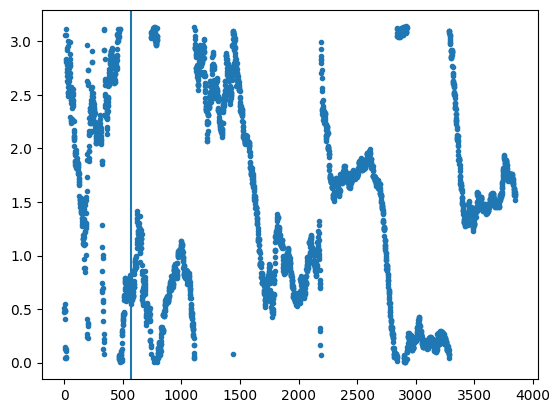

In [ ]:
plt.plot(mod_pi_phases, '.')
plt.axvline(x = 567)
#plt.xlim(540, 580)
len(my_phase)




(0.0, 200.0)

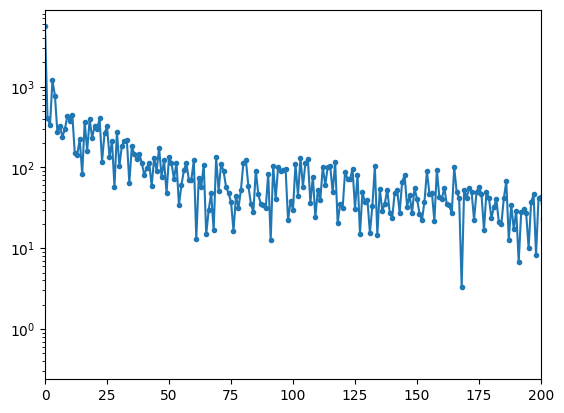

In [ ]:
fft_phase = abs(np.fft.fft(mod_pi_phases))
plt.semilogy(fft_phase, '.-')
plt.xlim(0, 200)



4002 4002


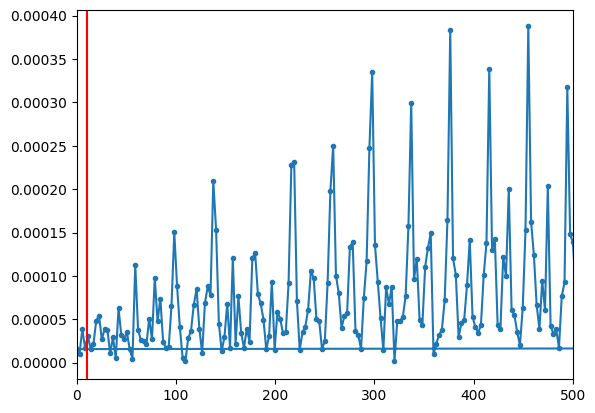

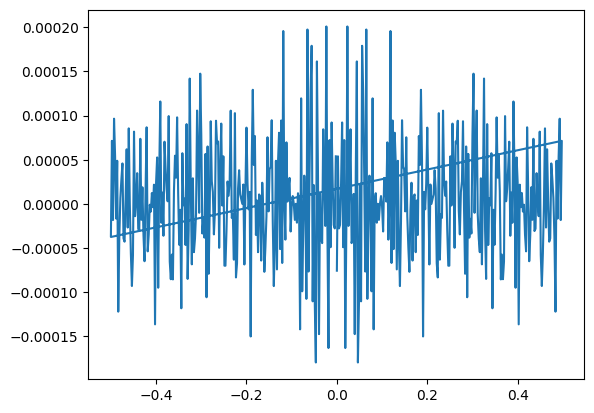

In [ ]:
x_list_all = x_list_all[0:4002]

fft_new = abs(np.fft.fft(x_list_all[0:4002]))/len(x_list_all[0:4002])*2
fft_new_padding = abs(np.fft.rfft(x_list_all-np.mean(x_list_all), n = len(x_list_all) * zero_padding_factor))/len(x_list_all)*2

freq_new = np.fft.fftfreq(len(x_list_all[0:4002]), d=1/sampling_frequency)
print(len(fft_new), len(x_list_norm))
freq_new_padding = np.fft.rfftfreq(len(x_list_all) *  zero_padding_factor, d=1/sampling_frequency)
plt.plot(freq_new, fft_new, '.-')
plt.axvline(x = 10, color = 'red')
plt.xlim(0,500)
plt.show()
plt.plot(np.fft.fftfreq(len(x_list_all[570:1000])),np.fft.fft(x_list_all[570:1000])/len(x_list_all[570:1000])*2)

In [ ]:
print(np.array(my_phase[0:100])%np.pi)

[0.50704085 0.47033426 0.48587264 0.49301529 0.47958534 0.55115125
 0.40557    0.12498974 0.14599834 0.04690508 3.06276755 0.05325496
 0.10685615 0.13012001 0.03905025 3.06122714 3.11329366 2.81259641
 2.82441876 2.8340735  2.77609862 2.71303093 2.71567133 2.67922922
 2.62964842 2.93840429 2.738252   2.91630578 3.00722441 2.57727242
 2.6161247  2.51922102 2.49015119 2.51397686 2.53220654 2.81955957
 2.95869355 2.75230835 2.62801817 2.49605782 2.54046232 2.48868632
 2.67525364 2.71423036 2.66749401 2.76784977 2.99252427 2.88156802
 2.83347596 2.77689769 2.80237921 2.70797789 2.67029744 2.29504463
 2.2404272  2.25859609 2.26565352 2.45286482 2.42408    2.57135658
 2.57701932 2.45616568 2.43299645 2.2758815  2.4435102  2.4404171
 2.4685257  2.41591057 2.41525137 2.42127807 2.38226132 2.45756151
 2.41509497 2.40090261 2.44489284 2.50304519 2.55659298 2.51557179
 2.25646232 2.25631384 2.09729326 2.01919498 2.11521485 2.1140646
 2.17475906 2.14969808 2.10125257 2.07679214 1.97280762 1.939611

deg = [i *180/np.pi for i in my_phase ]
print(deg)
unwrap_deg = np.unwrap(np.array(deg))
plt.plot(deg, '.')

In [ ]:
#np.diff(np.array(my_phase))
a = np.array(mux_all).reshape(-1,1)[:10]
one_dimensional_array = a.ravel()
print(one_dimensional_array)


[124516.66617999 124516.71580823 124516.86344565 124516.99297824
 124517.00560603 124517.05150088 124517.09163876 124517.28187283
 124517.39491427 124517.50108208]


In [ ]:

print(y_data_0)

[ 8.61371312e-04  8.30556987e-04  1.07279108e-03  1.00115315e-03
  9.79627611e-04  5.69544902e-04  6.38049943e-04 -6.17702315e-04
 -9.58010098e-04 -1.08941356e-03 -8.88480940e-04 -5.49056455e-05
  4.85087373e-04  1.04551778e-03  9.16406290e-04  3.12999031e-04
 -4.32586810e-04 -9.94559934e-04 -7.64142444e-04 -2.16746350e-04
  6.08100410e-04  1.03805404e-03  9.53290781e-04  3.39808806e-04
 -4.22774296e-04 -9.94401957e-04 -7.11846238e-04 -1.58147886e-04
  5.38148073e-04  1.01549775e-03  9.25016660e-04  8.90910392e-05
 -8.12236361e-04 -1.07339570e-03 -7.70644735e-04 -1.83912196e-04
  7.62612747e-04  9.64890004e-04  7.37084911e-04  2.58182503e-04
 -9.11680465e-04 -1.10194325e-03 -6.75338637e-04 -2.19002496e-04
  6.03099299e-04  9.44647325e-04  9.28418226e-04  1.86663020e-04
 -5.13209729e-04 -9.56822380e-04 -1.01529586e-03 -3.50989880e-05
  4.46766738e-04  1.06466206e-03  8.18618682e-04  9.89660022e-05
 -8.19341372e-04 -1.07284749e-03 -9.44186045e-04 -6.01279599e-04
 -1.65424948e-04  1.23691

## Phase unwrapping

my_phi = my_phase

for i in range(len(my_phase)-1):
    #print(my_phase[i])
    while np.diff(np.array(my_phi))[i]<0:
        if np.diff(np.array(my_phi))[i]<0:
             my_phase[i+1] = my_phase[i+1] + np.pi
#print(my_phase)
plt.scatter(mux[0:len(my_phase)+0],np.array(my_phase), s = 0.1)
#print(mux[10:len(my_phase)+10],np.diff(np.array(my_phase)))
plt.xlabel('mux')
plt.ylabel('unwrapped phase')
#plt.xlim(0,6)
#plt.ylim(0, 200)

for i in range(len(my_phase) - 1):
    while np.diff(np.array(my_phase))[i] < 0:
        my_phase[i + 1] = my_phase[i + 1] + 2*np.pi

    while np.diff(np.array(my_phase))[i] >= 2*np.pi:
        my_phase[i + 1] = my_phase[i + 1] - np.pi
plt.scatter(mux[:len(my_phase)], np.array(my_phase), s=0.1)
plt.xlabel('mux')
plt.ylabel('unwrapped phase')
plt.show()




In [ ]:
phase_deg = np.mod(np.linspace(0 ,720, 19), 360) - 180

In [ ]:
phase_deg

array([-180., -140., -100.,  -60.,  -20.,   20.,   60.,  100.,  140.,
       -180., -140., -100.,  -60.,  -20.,   20.,   60.,  100.,  140.,
       -180.])

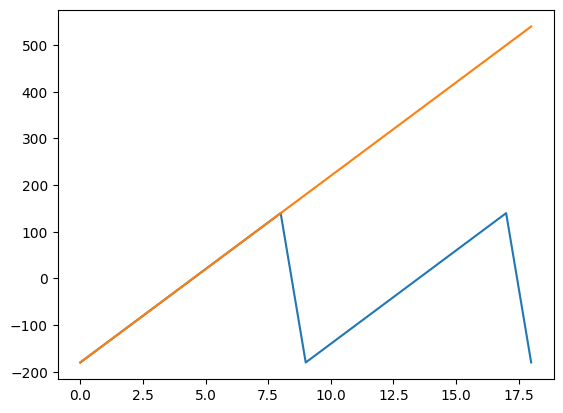

In [ ]:
plt.plot(phase_deg)
plt.plot(np.unwrap(phase_deg, period=360))